In [1]:
from IPython.display import HTML, display
from arch.univariate import arch_model
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np

In [2]:
# Stock tickers
S_P500 = "^GSPC"
STOCKS = [
    "AAPL",
    "AMZN"
]
SYMBOLS = [S_P500] + STOCKS

In [3]:
# Date range (look back 20 years)
END_DATE = datetime.now()
START_DATE = END_DATE.replace(year=END_DATE.year-20)

In [4]:
M = 20

In [5]:
# Returns stock data from provided date range
def get_stocks_data(symbols, from_date=START_DATE, to_date=END_DATE, keep=["Adj Close"]):
    if isinstance(symbols, str):
        df = web.DataReader(symbols, "yahoo", from_date, to_date)[keep]
        return df.rename(columns={column: (F"{symbols} {column}" if len(keep) > 1 else symbols) for column in df})
    elif isinstance(symbols, list):
        if symbols:
            df = web.DataReader(symbols[0], "yahoo", from_date, to_date)[keep]
            df.rename(columns={column: (F"{symbols[0]} {column}" if len(keep) > 1 else symbols[0]) for column in df}, inplace=True)
            for s in symbols[1:]:
                temp = web.DataReader(s, "yahoo", from_date, to_date)[keep]
                temp.rename(columns={column: (F"{s} {column}" if len(keep) > 1 else s) for column in temp}, inplace=True)

                df = pd.merge(df, temp, how="inner", on="Date")
            return df
        else: raise ValueError("list of 'symbols' must not be empty")
    else:
        raise TypeError("'symbols' must be either a string or list of symbols")

In [6]:
stock_data = get_stocks_data(SYMBOLS).sort_index()
display(HTML(stock_data.head().to_html()))

,^GSPC,AAPL,AMZN
Date,,,
2002-05-14,1097.280029,0.391018,18.809999
2002-05-15,1091.069946,0.385980,19.940001
2002-05-16,1098.229980,0.384911,19.610001
2002-05-17,1106.589966,0.381857,19.160000
2002-05-20,1091.880005,0.377735,19.389999


In [7]:
# Compute daily stock log returns per day
K_daily = np.log(stock_data / stock_data.shift(1))
display(HTML(K_daily.head().to_html()))

,^GSPC,AAPL,AMZN
Date,,,
2002-05-14,NaN,NaN,NaN
2002-05-15,-0.005676,-0.012968,0.058339
2002-05-16,0.006541,-0.002772,-0.016688
2002-05-17,0.007583,-0.007967,-0.023215
2002-05-20,-0.013382,-0.010853,0.011933


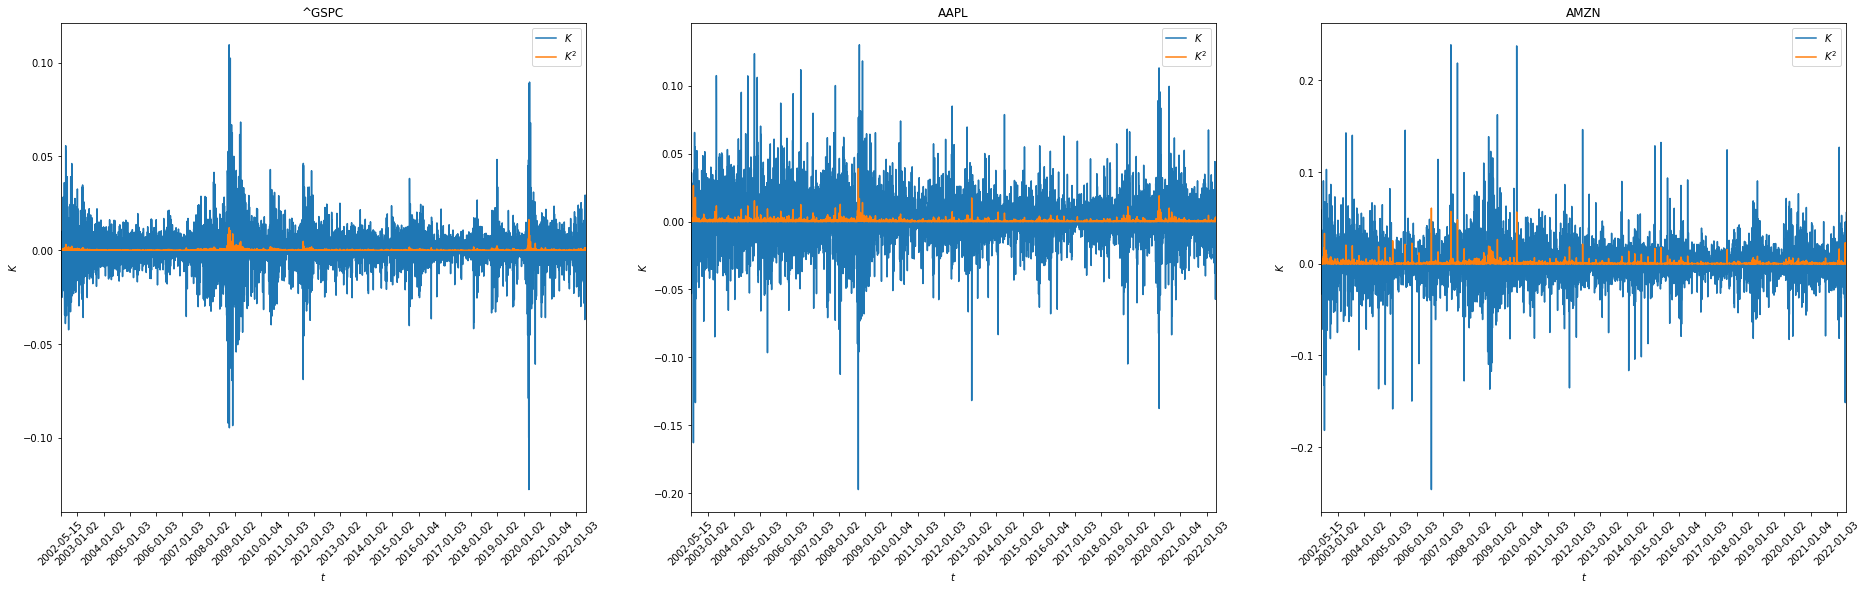

In [8]:
# Plots of log-returns and log-returns sqaured per period for different tickers
plt.figure(figsize=(32, 9))
for i, symbol in enumerate(SYMBOLS):
    symbol_data = K_daily.loc[~pd.isnull(K_daily[symbol])].reset_index()
    symbol_data["Year"] = symbol_data["Date"].dt.year
    plt.subplot(1, len(SYMBOLS), i+1)
    plt.plot(symbol_data[symbol].values, label="$K$")
    plt.plot(symbol_data[symbol].values ** 2, label="$K^{2}$")
    plt.title(symbol)
    plt.legend(loc="best")
    plt.xlabel("$t$")
    plt.ylabel("$K$")
    plt.xlim([0, len(symbol_data.index)-1])
    plt.xticks(symbol_data.drop_duplicates(subset="Year").index.values, symbol_data.drop_duplicates(subset="Year")["Date"].dt.date.values, rotation=45)

In [9]:
# Subtract out mean of daily log-returns
for symbol in SYMBOLS: K_daily[symbol] = K_daily[symbol] - K_daily[symbol].mean()

In [10]:
# Compute the autocorrelations of the daily log-returns of the different tickers
autocorrs = {F"{symbol}{' K^2' if p == 2 else''}": [(K_daily[symbol] ** p).autocorr(lag=l) for l in range(0, 21)] for p in [1, 2] for symbol in SYMBOLS}
autocorrs["Lag"] = [lag for lag in range(0, M+1)]
autocorrs = pd.DataFrame(autocorrs)
display(HTML(autocorrs.head().to_html()))

,^GSPC,AAPL,AMZN,^GSPC K^2,AAPL K^2,AMZN K^2,Lag
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0
1,-0.125302,-0.020563,-0.003643,0.331088,0.162822,0.085430,1
2,0.007818,-0.019012,-0.037953,0.463434,0.127818,0.037741,2
3,0.015288,-0.006879,-0.008280,0.262450,0.120233,0.024602,3
4,-0.035050,0.046257,-0.003411,0.324667,0.109080,0.055255,4


# a

In [11]:
N = len(K_daily.index)
nu = 5

In [12]:
eps = [
    "Gaussian",
    "Students T"
]

In [13]:
# Simple function to simulate GARCH model, given coefficients and a random signal
def garch(df, zt, omega=0.5, alpha=[0.6], beta=[0.4]):
    w = len(zt.columns)
    for t in tqdm(range(len(zt.index)), desc="GARCH Simulation", leave=True, position=0):
        # Assumes all signals at negative time are 0
        df.loc[t, :] = omega + \
            sum([a * (zt.loc[t-p] ** 2 if t-p>=0 else np.zeros([1, w])) * (df.loc[t-p] if t-p>=0 else np.zeros([1, w])) for p, a in enumerate(alpha, start=1)]) + \
            sum([b * (df.loc[t-q] if t-q>=0 else np.zeros([1, w])) for q, b in enumerate(beta, start=1)])

In [14]:
# Generate random signals and initialize storage fro GARCH simulation
zt = pd.DataFrame(columns=eps, data=np.concatenate((np.random.normal(size=[N, 1]), np.random.standard_t(nu, [N, 1]) / np.sqrt(nu / (nu - 2))), axis=1))
sigma2 = pd.DataFrame(columns=eps, dtype=float)

In [15]:
# Perform simulation and retrieve residuals from it
garch(sigma2, zt)
rt = np.sqrt(sigma2) * zt

GARCH Simulation: 100%|██████████| 5037/5037 [00:05<00:00, 877.56it/s]


In [16]:
display(HTML(zt.head().to_html()))
display(HTML(sigma2.head().to_html()))
display(HTML(rt.head().to_html()))

,Gaussian,Students T
0,-0.374318,1.323728
1,0.732789,1.503743
2,0.713707,1.259892
3,-2.083687,0.322898
4,-0.251190,-4.160708


,Gaussian,Students T
0,0.500000,0.500000
1,0.742034,1.225677
2,1.035888,2.653203
3,1.230950,4.088183
4,4.199069,2.391021


,Gaussian,Students T
0,-0.264683,0.936017
1,0.631235,1.664799
2,0.726401,2.052195
3,-2.311813,0.652875
4,-0.514730,-6.433672


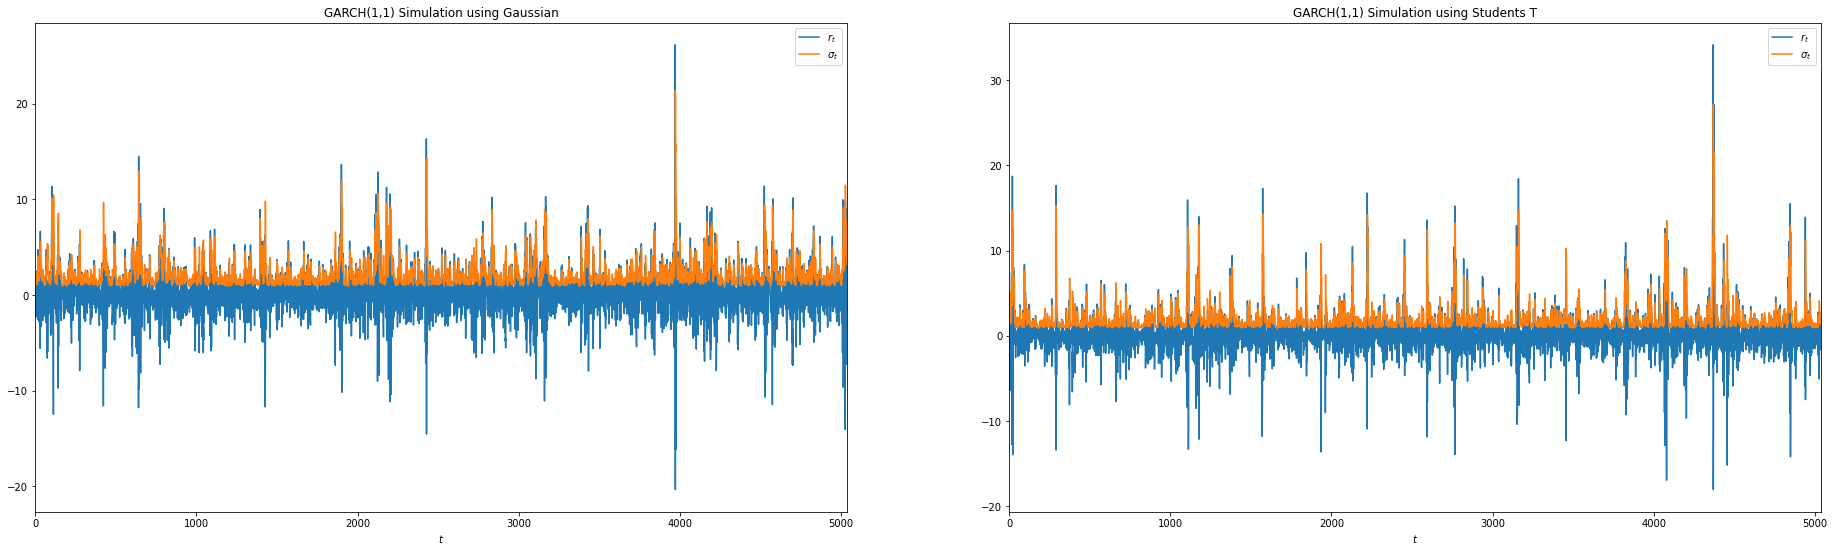

In [17]:
# Plot residuals and volatility from the GARCH simulation
plt.figure(figsize=(32, 9))
for i, column in enumerate(zt.columns, start=1):
    plt.subplot(1, 2, i)
    plt.plot(rt[column], label="$r_{t}$")
    plt.plot(np.sqrt(sigma2[column]), label="$\sigma_{t}$")
    plt.legend(loc="best")
    plt.title(F"GARCH(1,1) Simulation using {column}")
    plt.xlim([0, len(zt.index)-1])
    plt.xticks()
    plt.xlabel("$t$")

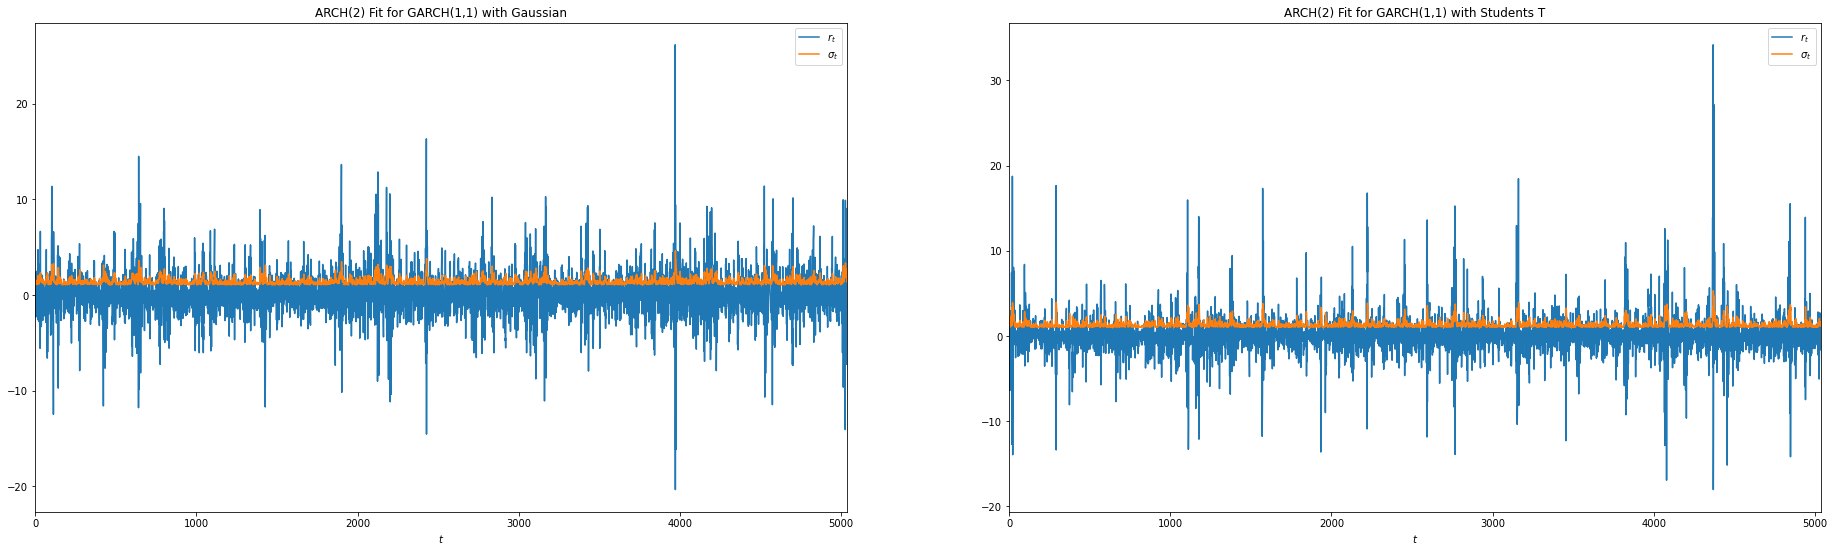

In [18]:
# Fit a GARCH(1,1) and ARCH(2) model to residuals derived from simulation
plt.figure(figsize=(32, 9))
model_fits = pd.DataFrame(columns=["zt", "model", "omega", "alpha[1]", "beta[1]/alpha[2]"])
for i, column in enumerate(rt.columns, start=1):
    # GARCH(1,1)
    garch_results = arch_model(rt[column]).fit(disp="off")
    model_fits.loc[len(model_fits.index)+1] = [column, "GARCH(1,1)", garch_results.params["omega"], garch_results.params["alpha[1]"], garch_results.params["beta[1]"]]

    # ARCH(2)
    arch_results = arch_model(rt[column], vol="ARCH", p=2).fit(disp="off")
    model_fits.loc[len(model_fits.index)+1] = [column, "ARCH(2)", arch_results.params["omega"], arch_results.params["alpha[1]"], arch_results.params["alpha[2]"]]

    # Students' T random samples tend to produce much larger outliers because of inherent heavy tail characteristic
    plt.subplot(1, 2, i)
    plt.plot(arch_results.resid, label="$r_{t}$")
    plt.plot(np.sqrt(arch_results.conditional_volatility), label="$\sigma_{t}$")
    plt.legend(loc="best")
    plt.title(F"ARCH(2) Fit for GARCH(1,1) with {column}")
    plt.xlim([0, len(rt.index)-1])
    plt.xticks()
    plt.xlabel("$t$")

In [19]:
# GARCH coefficients are very close to the true ones used in simulation for both Gaussian and Students' T zt
display(HTML(model_fits.head().to_html()))

,zt,model,omega,alpha[1],beta[1]/alpha[2]
1,Gaussian,"GARCH(1,1)",0.504822,0.544766,0.423154
2,Gaussian,ARCH(2),1.242582,0.597123,0.306907
3,Students T,"GARCH(1,1)",0.489719,0.535700,0.434876
4,Students T,ARCH(2),1.131013,0.653746,0.301593


# b

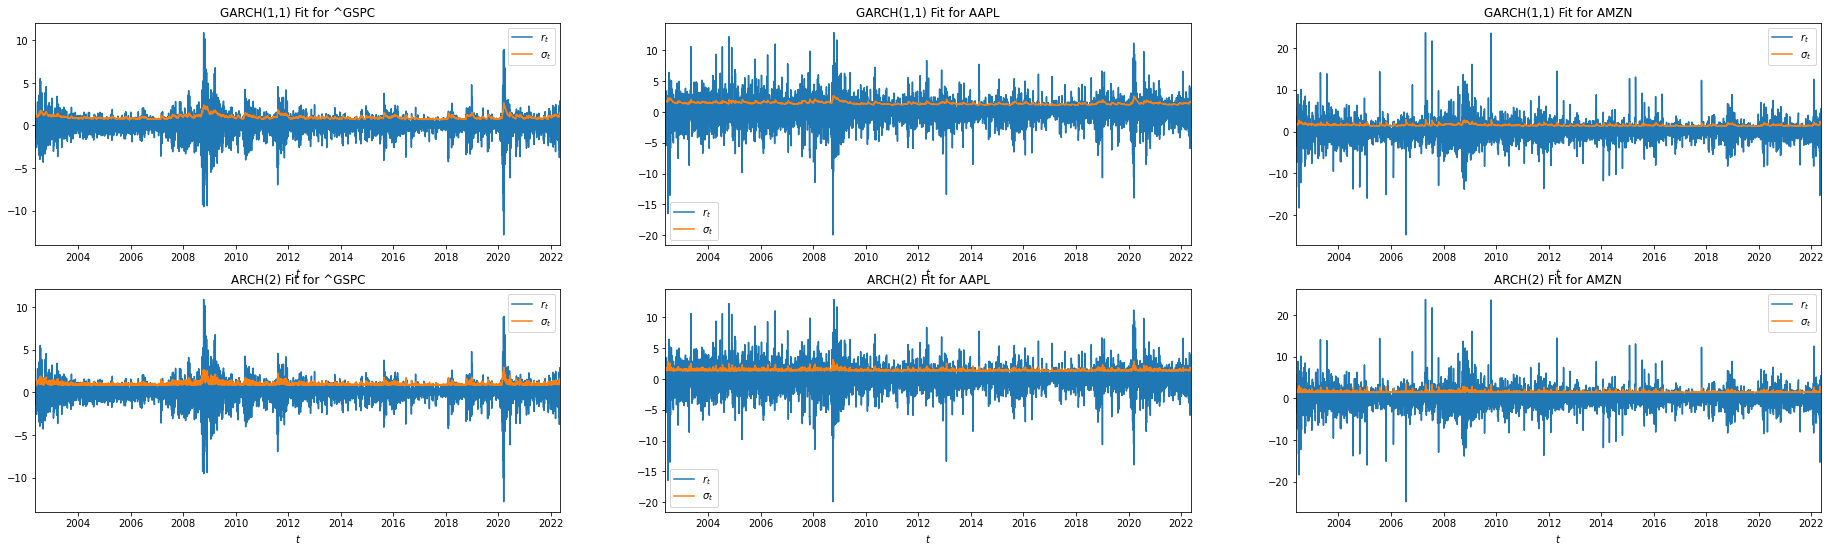

In [20]:
# Fit a GARCH(1,1) and ARCH(2) model to the real financial data pulled
plt.figure(figsize=(32, 9))
for i, symbol in enumerate(SYMBOLS, start=1):
    garch_results = arch_model(100 * K_daily.loc[~pd.isnull(K_daily[symbol]), symbol]).fit(disp="off")
    arch_results = arch_model(100 * K_daily.loc[~pd.isnull(K_daily[symbol]), symbol], vol="ARCH", p=2).fit(disp="off")

    plt.subplot(2, 3, i)
    plt.plot(garch_results.resid.dropna(), label="$r_{t}$")
    plt.plot(np.sqrt(garch_results.conditional_volatility.dropna()), label="$\sigma_{t}$")
    plt.legend(loc="best")
    plt.title(F"GARCH(1,1) Fit for {symbol}")
    plt.xlim([min(arch_results.resid.index), max(arch_results.resid.index)])
    plt.xlabel("$t$")

    plt.subplot(2, 3, i + 3)
    plt.plot(arch_results.resid, label="$r_{t}$")
    plt.plot(np.sqrt(arch_results.conditional_volatility), label="$\sigma_{t}$")
    plt.legend(loc="best")
    plt.title(F"ARCH(2) Fit for {symbol}")
    plt.xlim([min(arch_results.resid.index), max(arch_results.resid.index)])
    plt.xlabel("$t$")